In [1]:
#hide
from utils import *
hc(
    "On Musical Onset Detection via the S-Transform",
    [""],
    "https://arxiv.org/abs/1712.02567"
)

# Author(s)

Silva et. al.

# Algorithm - 1 (Onset Envelopes By Band Splitting)

## Loading Audio Signal

We load a $4$ second audio clip from a song at a sampling rate of $44100$ Hz. The clip is chosen to have percussive elements presence.

In [2]:
#hide
# Utility functions
def spectrogram(y, sr, N, H, gamma=None):
    """
    Compute magnitude spectrogram.

    Parameters
    ----------
    y: ndarray
        Signal.
    N: int
        - Number of fft bins (samples).
        - window length is same.
    H: int
        - Hop length (samples).
    gamma: int
        - Log compression factor
        
    Returns
    -------
    ndarray
        2D spectrogram matrix.
    ndarray
        1D frequency axis.
    ndarray
        1D time axis.
    """    
    import librosa
    S = librosa.stft(y=y, n_fft=N, win_length=N, hop_length=H, center=True, window="hann")
    S = np.abs(S)
    S_fr = sr / H # Frame rate (Hz)
    if gamma is not None:
        S = np.log(1 + gamma * S)
    S_f = np.arange(S.shape[0]) * (sr / N)
    S_t = np.arange(S.shape[1]) / S_fr

    return S, S_f, S_t

In [3]:
import modusa as ms
import numpy as np

audio_fp = "../../../data/samples/Sample Song.mp3"
SR = 44100 # Hz

# Load an audio signal
x, sr, title = ms.load(audio_fp, sr=SR, clip=(70, 74))

## Downsampling

We compute $y[n]$ which is a downsampled version of $x[n]$ with a downsampling factor of $D = 40$.

$y[n] = x[nD]$

The length of $y$ is given by $M = \lfloor{1 + \frac{N-1}{D}} \rfloor$

where,
- $\lfloor \cdot \rfloor$ is floor function (rounds down to the nearest integer)

In [4]:
D = 40 # Downsampling factor => sr = 1102.5 hz

y = x[::D]
sr = sr // D

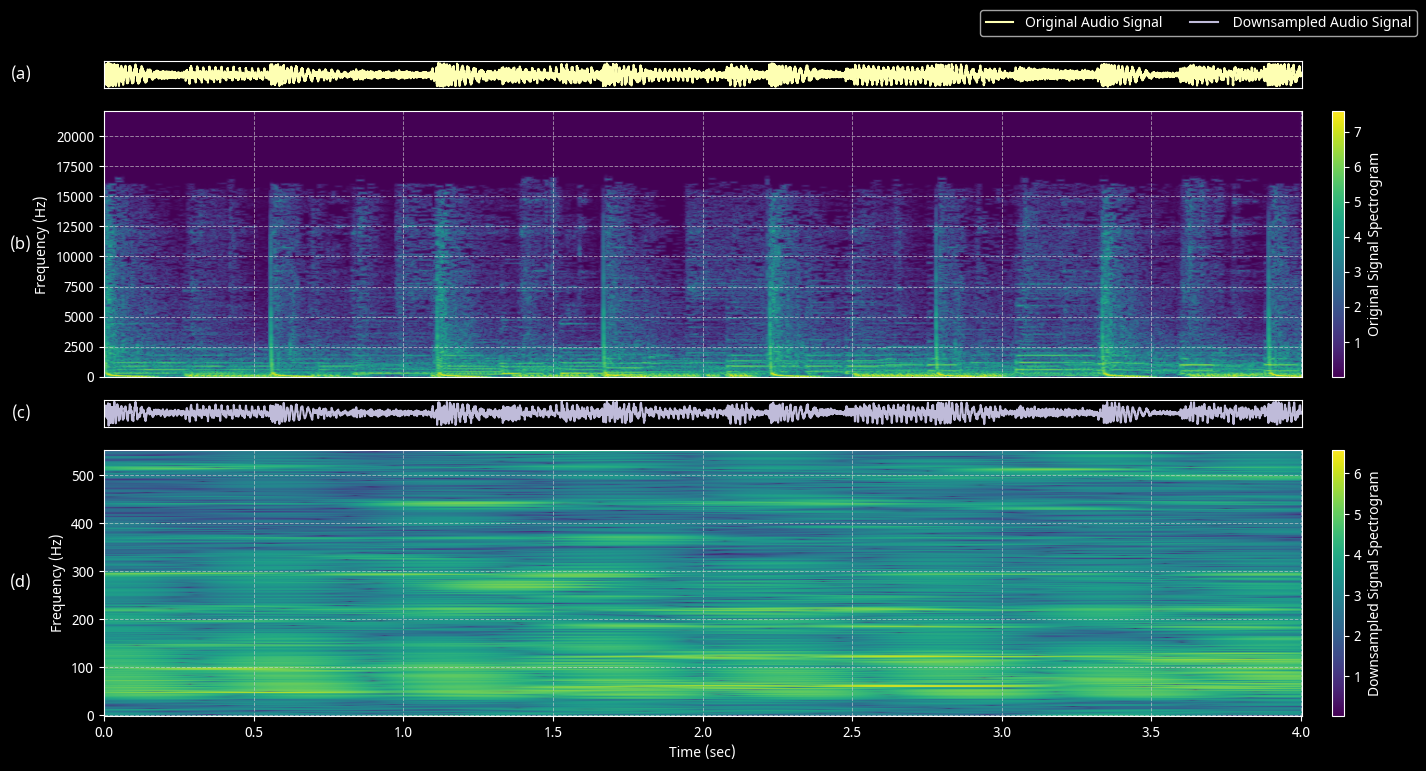

In [8]:
# Visualization
fig = ms.fig("amam", abc=True)
fig.add_signal(x, np.arange(x.size) / SR, label="Original Audio Signal", grid=False)
fig.add_matrix(*spectrogram(x, SR, 1024, 160, 10), o="lower", label="Original Signal Spectrogram", ylabel="Frequency (Hz)")

fig.add_signal(y, np.arange(y.size) / sr, label=" Downsampled Audio Signal", grid=False)
fig.add_matrix(*spectrogram(y, sr, 1024, 160 // D, 10), o="lower", label="Downsampled Signal Spectrogram", ylabel="Frequency (Hz)")

fig.add_xlabel("Time (sec)")
fig.add_legend(0.92)

Comparing (b), the spectrogram of the original signal (a), with (d), the spectrogram of the downsampled signal (c), we observe that the onset information, visible as vertical lines in (b) has completely disappeared in the latter due to the low sampling rate.

## Discrete Fourier Transform

We compute the DFT $Y[k]$ of the downsampled signal $y[n]$.

$Y[k] = \frac{1}{M} \sum_{n=0}^{M-1}{y[n] \cdot e^{-j2\pi n k / M}}$

This will be used in the next step to compute S-Transform.

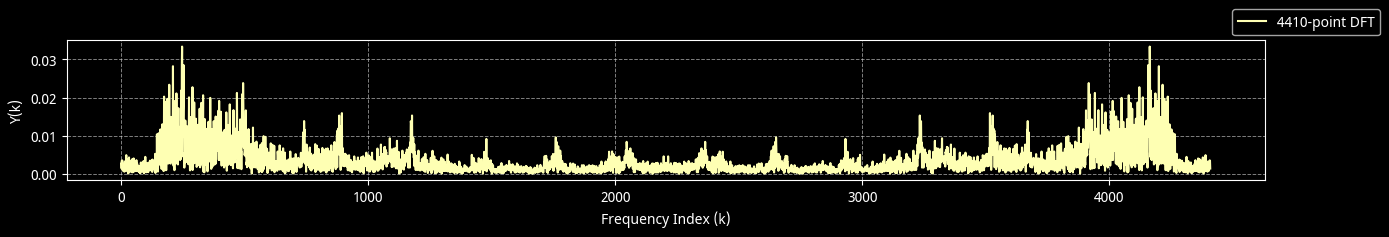

In [9]:
N = y.size
M = y.size
Y = np.zeros(M, dtype=np.complex64)

ns = np.arange(N)
ks = np.arange(M)

for k in ks:
    exp_term = np.exp(-2j * np.pi * ns * k / M)
    Y[k] = (1 / M) * np.sum(y * exp_term)

# Visualization
fig = ms.fig("s")
fig.add_signal(np.abs(Y), label=f"{M}-point DFT", ylabel="Y(k)")
fig.add_xlabel("Frequency Index (k)")
fig.add_legend()

## Discrete S-Transform

$
F[p, n] =
\begin{cases}
\sum_{m=0}^{M-1} Y[m+n] \exp\left( \frac{j 2 \pi m p}{N} - \frac{2 \pi^2 m^2}{n^2} \right), & n \neq 0, \\[1.2em]
{\frac{1}{M} \sum_{m=0}^{M-1}{y[m]}}, & n = 0.
\end{cases}
$

where $n = 0, 1, 2, ..., M-1$ and $p = 0, 1, ..., \frac{M}{2} - 1$

A naive implementation of the S-Transform has a complexity of $O(N^3)$, but more efficient algorithms reduce this to $O(N \log N)$. In this work, we use the Python library **stockwell** to compute the Discrete S-Transform (DST). Consequently, the previously computed $Y[k]$ is no longer required explicitly.

For completeness, an implementation of the DST from scratch is provided in the appendix.

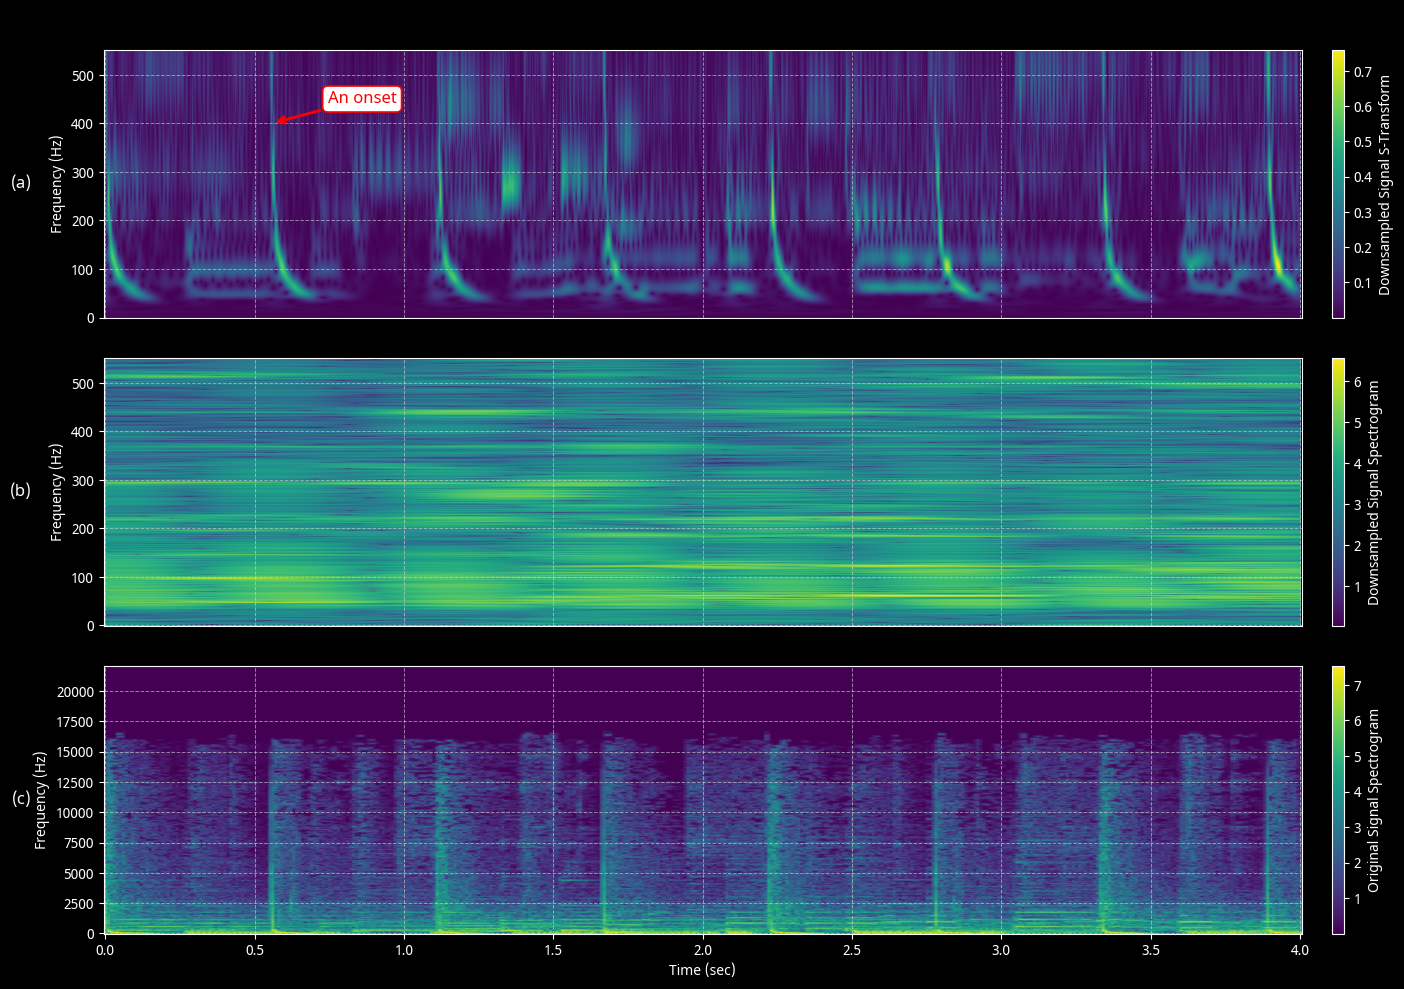

In [22]:
from stockwell import st

F = st.st(y, lo=0, hi=int(y.size/2)) # shape = (y.size / 2, y.size): S-Transform using the library
S = np.abs(F)
S_ts = np.arange(F.shape[1]) / sr
S_fs = np.linspace(0, sr / 2, F.shape[0])

# Visualization
fig = ms.fig("mmm", abc=True)
fig.add_matrix(np.abs(S), S_fs, S_ts, o="lower", label="Downsampled Signal S-Transform", ylabel="Frequency (Hz)")
fig.add_arrows((0.56, 400), "An onset", text_offset=(0.3, 50))
fig.add_matrix(*spectrogram(y, sr, 1024, 160 // D, 10), o="lower", label="Downsampled Signal Spectrogram", ylabel="Frequency (Hz)")
fig.add_matrix(*spectrogram(x, SR, 1024, 441, 10), o="lower", label="Original Signal Spectrogram", ylabel="Frequency (Hz)") # Plotting the spectrogram of original audio signal for analysis
fig.add_xlabel("Time (sec)")

In (a), we see sharp vertical lines that align with the onset locations when compared to (c), the spectrogram of the original signal. Interestingly, while the spectrogram in (b) of the downsampled signal appears too blurred for reliable onset detection, the S-Transform applied to the same downsampled signal is still able to capture the onsets effectively.

# Notebook Contributors

Ankit Anand

# Appendix

## S Transform

[source](https://www.kurims.kyoto-u.ac.jp/~kyodo/kokyuroku/contents/pdf/2102-01.pdf)

In [ ]:
#hide
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

def stockwell_transform(data, lo=0, hi=None):
    """
    Pure Python implementation of the Stockwell Transform.
    
    Parameters
    ----------
    data : array_like
        Input real-valued time series data
    lo : int, optional
        Lowest frequency index (default: 0)
    hi : int, optional
        Highest frequency index (default: len(data)//2)
    
    Returns
    -------
    result : ndarray
        Complex S-transform array with shape (n_freqs, n_times)
        where n_freqs = hi - lo + 1
    """
    data = np.asarray(data, dtype=np.float64)
    n = len(data)
    
    # Set default frequency range
    if hi is None:
        hi = n // 2
    
    n_freqs = hi - lo + 1
    
    # Initialize result array (complex)
    result = np.zeros((n_freqs, n), dtype=np.complex128)
    
    # Convert input to complex and compute mean
    h = np.fft.fft(data)
    mean_val = np.mean(data)
    
    # Apply Hilbert transform
    # Upper half-circle gets multiplied by 2
    # Lower half-circle gets set to 0
    # Real axis (DC and Nyquist) left alone
    l2 = (n + 1) // 2
    h[1:l2] *= 2.0
    h[l2:] = 0.0
    
    # Process each frequency
    for idx, freq in enumerate(range(lo, hi + 1)):
        if freq == 0:
            # DC component: just the mean
            result[idx, :] = mean_val
        else:
            # Create Gaussian window in frequency domain
            # The Gaussian is exp(-2*pi^2*m^2/n^2) where n is the frequency
            gauss_window = np.zeros(n, dtype=np.float64)
            
            # Compute Gaussian for positive and negative frequencies
            gauss_window[0] = np.exp(-2.0 * np.pi**2 * 0**2 / freq**2)
            l2 = n // 2 + 1
            for m in range(1, l2):
                g_val = np.exp(-2.0 * np.pi**2 * m**2 / freq**2)
                gauss_window[m] = g_val
                gauss_window[n - m] = g_val
            
            # Shift the FFT and multiply by Gaussian
            # This corresponds to G[i] = H[freq + i] * gauss[i]
            G = np.zeros(n, dtype=np.complex128)
            for i in range(n):
                k = freq + i
                if k >= n:
                    k -= n
                G[i] = h[k] * gauss_window[i]
            
            # Inverse FFT to get time-domain result
            result[idx, :] = np.fft.ifft(G)
    
    return result


def inverse_stockwell_transform(st_result, lo=0, hi=None, n=None):
    """
    Inverse Stockwell Transform.
    
    Parameters
    ----------
    st_result : ndarray
        S-transform output (n_freqs x n_times)
    lo : int
        Lowest frequency index used in forward transform
    hi : int, optional
        Highest frequency index used in forward transform
    n : int, optional
        Length of output signal (default: number of time points)
    
    Returns
    -------
    result : ndarray
        Reconstructed real-valued signal
    """
    n_freqs, n_times = st_result.shape
    
    if n is None:
        n = n_times
    if hi is None:
        hi = lo + n_freqs - 1
    
    # Sum across time for each frequency
    H = np.zeros(n, dtype=np.complex128)
    
    for idx, freq in enumerate(range(lo, hi + 1)):
        H[freq] = np.sum(st_result[idx, :])
    
    # Invert the Hilbert transform
    l2 = (n + 1) // 2
    H[1:l2] /= 2.0
    
    # Restore negative frequencies by conjugate symmetry
    l2 = n // 2 + 1
    for i in range(l2, n):
        H[i] = np.conj(H[n - i])
    
    # Inverse FFT
    result = np.fft.ifft(H)
    
    return np.real(result)

F_custom = stockwell_transform(y, 0, int(y.size/2))
F_custom_ts = np.arange(F_custom.shape[1]) / sr
F_custom_fs = np.linspace(0, y.size/2, F_custom.shape[0])

fig = ms.fig("mms")
fig.add_matrix(np.abs(F), fs, ts, o="lower")
fig.add_matrix(np.abs(F_custom), F_custom_fs, F_custom_ts, o="lower")
fig.add_signal(np.sum(np.abs(F), axis=0), ts)